#Importing Libraries

In [ ]:
import numpy as np
import random
import os
import time
from collections import deque
from enum import Enum
from collections import namedtuple
import math
import sys


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

# Setting up the game enviroment

In [ ]:
class Direction(Enum):
    RIGHT = 1
    LEFT = 2
    UP = 3
    DOWN = 4

In [ ]:
Point = namedtuple('Point','x , y')
BLOCK_SIZE=10

In [ ]:
class SnakeGameAI:
    def __init__(self,w=200,h=200):
        self.w = w
        self.h = h
        self.reset()

    def reset(self):
        self.direction = Direction.RIGHT
        self.head = Point(self.w/2,self.h/2)
        self.snake = [self.head,
                      Point(self.head.x-BLOCK_SIZE,self.head.y),
                      Point(self.head.x-(2*BLOCK_SIZE),self.head.y)]
        self.score = 0
        self.food = None
        self._place__food()
        self.frame_iteration = 0
      
    def _place__food(self):
        x = random.randint(0,(self.w-BLOCK_SIZE)//BLOCK_SIZE)*BLOCK_SIZE
        y = random.randint(0,(self.h-BLOCK_SIZE)//BLOCK_SIZE)*BLOCK_SIZE
        self.food = Point(x,y)
        if(self.food in self.snake):
            self._place__food()

    def play_step(self,action):
        self.frame_iteration+=1
            
        # 1. Move
        self._move(action)
        self.snake.insert(0,self.head)

        # 2. Check if game Over
        reward = 0  # eat food: +10 , game over: -10 , else: 0
        game_over = False 
        if(self.is_collision() or self.frame_iteration > 100*len(self.snake) ):
            game_over=True
            reward = -10
            return reward,game_over,self.score

        # 3. Place new Food or just move
        if(self.head == self.food):
            self.score+=1
            reward=10
            self._place__food()
            
        else:
            self.snake.pop()
        
        return reward,game_over,self.score

    def _move(self,action):
        # Action
        # [1,0,0] -> Straight
        # [0,1,0] -> Right Turn 
        # [0,0,1] -> Left Turn

        clock_wise = [Direction.RIGHT,Direction.DOWN,Direction.LEFT,Direction.UP]
        idx = clock_wise.index(self.direction)
        if np.array_equal(action,[1,0,0]):
            new_dir = clock_wise[idx]
        elif np.array_equal(action,[0,1,0]):
            next_idx = (idx + 1) % 4
            new_dir = clock_wise[next_idx] # right Turn
        else:
            next_idx = (idx - 1) % 4
            new_dir = clock_wise[next_idx] # Left Turn
        self.direction = new_dir

        x = self.head.x
        y = self.head.y
        if(self.direction == Direction.RIGHT):
            x+=BLOCK_SIZE
        elif(self.direction == Direction.LEFT):
            x-=BLOCK_SIZE
        elif(self.direction == Direction.DOWN):
            y+=BLOCK_SIZE
        elif(self.direction == Direction.UP):
            y-=BLOCK_SIZE
        self.head = Point(x,y)

    def is_collision(self,pt=None):
        if(pt is None):
            pt = self.head
        #hit boundary
        if(pt.x>self.w-BLOCK_SIZE or pt.x<0 or pt.y>self.h - BLOCK_SIZE or pt.y<0):
            return True
        if(pt in self.snake[1:]):
            return True
        return False

In [ ]:
game = SnakeGameAI()
game.reset()

# Defining Models

# DQN Model

In [ ]:
class Linear_QNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

    def save(self, file_name='model.pth'):
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)

In [ ]:
class QTrainer:
    def __init__(self, model, lr, gamma):
        self.lr = lr
        self.gamma = gamma
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

    def train_step(self, state, action, reward, next_state, done):
        state = torch.tensor(state, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float)
        # (n, x)

        if len(state.shape) == 1:
            # (1, x)
            state = torch.unsqueeze(state, 0)
            next_state = torch.unsqueeze(next_state, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            done = (done, )

        # 1: predicted Q values with current state
        pred = self.model(state)

        target = pred.clone()
        for idx in range(len(done)):
            Q_new = reward[idx]
            if not done[idx]:
                Q_new = reward[idx] + self.gamma * torch.max(self.model(next_state[idx]))

            target[idx][torch.argmax(action[idx]).item()] = Q_new
    
        # 2: Q_new = r + y * max(next_predicted Q value) -> only do this if not done
        # pred.clone()
        # preds[argmax(action)] = Q_new
        self.optimizer.zero_grad()
        loss = self.criterion(target, pred)
        loss.backward()

        self.optimizer.step()

#SARSA Model

In [ ]:
class Linear_SarsaNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

    def save(self, file_name='model.pth'):
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)


In [ ]:
class SarsaTrainer:

    def __init__(self, model, lr, gamma):
        self.lr = lr
        self.gamma = gamma
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

    def train_step(self, state, action, reward, next_state, next_action, done):
        state = torch.tensor(state, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        reward = torch.tensor(reward, dtype=torch.float)
        
        
        
        if len(state.shape) == 1:
            state = torch.unsqueeze(state, 0)
            next_state = torch.unsqueeze(next_state, 0)
            reward = torch.unsqueeze(reward, 0)
            done = (done, )

        pred = self.model(state)
        target = pred.clone()

        for idx in range(len(done)):
            # Q_new = reward[idx]
            # if not done[idx]:
            #     Q_new = reward[idx] + self.gamma * torch.max(self.model(next_state[idx]))

            # target[idx][torch.argmax(action[idx]).item()] = Q_new

            action_n = None
            if np.array_equal(action[idx],[1,0,0]):
                action_n = 0
            elif np.array_equal(action[idx],[0,1,0]):
                action_n = 1
            elif np.array_equal(action[idx],[0,0,1]):
                action_n = 2
            
            action_nn = None
            if np.array_equal(next_action[idx],[1,0,0]):
                action_nn = 0
            elif np.array_equal(next_action[idx],[0,1,0]):
                action_nn = 1
            elif np.array_equal(next_action[idx],[0,0,1]):
                action_nn = 2

            Q_new = reward[idx]
            if not done and action_nn is not None:
                Q_new = reward[idx] + (self.gamma * self.model(next_state)[idx][action_nn] * (1 - done[idx]))
            
            if action_n is not None:
                target[idx][action_n] = Q_new
        
        self.optimizer.zero_grad()
        loss = self.criterion(target, pred)
        loss.backward()

        self.optimizer.step()

In [ ]:
import matplotlib.pyplot as plt
from IPython import display

plt.ion()

def plot(scores, mean_scores):
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Number of Games')
    plt.ylabel('Score')
    plt.plot(scores)
    plt.plot(mean_scores)
    plt.ylim(ymin=0)
    plt.text(len(scores)-1, scores[-1], str(scores[-1]))
    plt.text(len(mean_scores)-1, mean_scores[-1], str(mean_scores[-1]))
    plt.show(block=False)
    #plt.pause(.1)

# Creating Agent Class

In [ ]:
MAX_MEMORY = 100_000
BATCH_SIZE = 1000
LR = 0.001
N_GAMES = 500

#DQN

In [ ]:
class DQNAgent:
    def __init__(self):
        self.n_games = 0
        self.epsilon = 0 # randomness
        self.gamma = 0.9 # discount rate
        self.memory = deque(maxlen=MAX_MEMORY) # popleft()
        self.model = Linear_QNet(11, 256, 3)
        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)

    def get_state(self, game):
        head = game.snake[0]
        point_l = Point(head.x - 20, head.y)
        point_r = Point(head.x + 20, head.y)
        point_u = Point(head.x, head.y - 20)
        point_d = Point(head.x, head.y + 20)
        
        dir_l = game.direction == Direction.LEFT
        dir_r = game.direction == Direction.RIGHT
        dir_u = game.direction == Direction.UP
        dir_d = game.direction == Direction.DOWN

        state = [
            # Danger straight
            (dir_r and game.is_collision(point_r)) or 
            (dir_l and game.is_collision(point_l)) or 
            (dir_u and game.is_collision(point_u)) or 
            (dir_d and game.is_collision(point_d)),

            # Danger right
            (dir_u and game.is_collision(point_r)) or 
            (dir_d and game.is_collision(point_l)) or 
            (dir_l and game.is_collision(point_u)) or 
            (dir_r and game.is_collision(point_d)),

            # Danger left
            (dir_d and game.is_collision(point_r)) or 
            (dir_u and game.is_collision(point_l)) or 
            (dir_r and game.is_collision(point_u)) or 
            (dir_l and game.is_collision(point_d)),
            
            # Move direction
            dir_l,
            dir_r,
            dir_u,
            dir_d,
            
            # Food location 
            game.food.x < game.head.x,  # food left
            game.food.x > game.head.x,  # food right
            game.food.y < game.head.y,  # food up
            game.food.y > game.head.y  # food down
            ]

        return np.array(state, dtype=int)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE) # list of tuples
        else:
            mini_sample = self.memory

        # for state, action, reward, next_state, next_action, done in mini_sample:
        #     self.trainer.train_step(state, action, reward, next_state, next_action, done)

        states, actions, rewards, next_states, dones = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, dones)

    def train_short_memory(self, state, action, reward, next_state, done):
        self.trainer.train_step(state, action, reward, next_state, done)


    def get_action(self, state):
        # random moves: tradeoff exploration / exploitation
        self.epsilon = 80 - self.n_games
        final_move = [0,0,0]
        if random.randint(0, 200) < self.epsilon:
            move = random.randint(0, 2)
            final_move[move] = 1
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0)
            move = torch.argmax(prediction).item()
            final_move[move] = 1

        return final_move

In [ ]:
def trainDQN():
    plot_scores = []
    plot_mean_scores = []
    total_score = 0
    record = 0
    agent = DQNAgent()
    game = SnakeGameAI()
    while True:
        # get old state
        state_old = agent.get_state(game)

        # get move
        final_move = agent.get_action(state_old)

        # perform move and get new state
        reward, done, score = game.play_step(final_move)
        state_new = agent.get_state(game)

        # train short memory
        agent.train_short_memory(state_old, final_move, reward, state_new, done)

        # remember
        agent.remember(state_old, final_move, reward, state_new, done)

        if done:
            # train long memory, plot result
            game.reset()
            agent.n_games += 1
            agent.train_long_memory()

            if score > record:
                record = score
                agent.model.save()

            print('Game', agent.n_games, 'Score', score, 'Record:', record)

            plot_scores.append(score)
            total_score += score
            mean_score = total_score / agent.n_games
            plot_mean_scores.append(mean_score)
            if agent.n_games == N_GAMES:
              break
    plot(plot_scores, plot_mean_scores)

#SARSA

In [ ]:
class SARSAAgent:
    def __init__(self):
        self.n_games = 0
        self.epsilon = 0 # randomness
        self.gamma = 0.9 # discount rate
        self.memory = deque(maxlen=MAX_MEMORY) # popleft()
        self.model = Linear_SarsaNet(11, 256, 3)
        self.trainer = SarsaTrainer(self.model, lr=LR, gamma=self.gamma)

    def get_state(self, game):
        head = game.snake[0]
        point_l = Point(head.x - 20, head.y)
        point_r = Point(head.x + 20, head.y)
        point_u = Point(head.x, head.y - 20)
        point_d = Point(head.x, head.y + 20)
        
        dir_l = game.direction == Direction.LEFT
        dir_r = game.direction == Direction.RIGHT
        dir_u = game.direction == Direction.UP
        dir_d = game.direction == Direction.DOWN

        state = [
            # Danger straight
            (dir_r and game.is_collision(point_r)) or 
            (dir_l and game.is_collision(point_l)) or 
            (dir_u and game.is_collision(point_u)) or 
            (dir_d and game.is_collision(point_d)),

            # Danger right
            (dir_u and game.is_collision(point_r)) or 
            (dir_d and game.is_collision(point_l)) or 
            (dir_l and game.is_collision(point_u)) or 
            (dir_r and game.is_collision(point_d)),

            # Danger left
            (dir_d and game.is_collision(point_r)) or 
            (dir_u and game.is_collision(point_l)) or 
            (dir_r and game.is_collision(point_u)) or 
            (dir_l and game.is_collision(point_d)),
            
            # Move direction
            dir_l,
            dir_r,
            dir_u,
            dir_d,
            
            # Food location 
            game.food.x < game.head.x,  # food left
            game.food.x > game.head.x,  # food right
            game.food.y < game.head.y,  # food up
            game.food.y > game.head.y  # food down
            ]

        return np.array(state, dtype=int)

    def remember(self, state, action, reward, next_state, next_action, done):
        self.memory.append((state, action, reward, next_state, next_action, done))

    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE) # list of tuples
        else:
            mini_sample = self.memory

        # for state, action, reward, next_state, next_action, done in mini_sample:
        #     self.trainer.train_step(state, action, reward, next_state, next_action, done)

        states, actions, rewards, next_states, next_actions, dones = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, next_actions, dones)

    def train_short_memory(self, state, action, reward, next_state, next_action, done):
        self.trainer.train_step(state, action, reward, next_state, next_action, done)


    def get_action(self, state):
        # random moves: tradeoff exploration / exploitation
        self.epsilon = 80 - self.n_games
        final_move = [0,0,0]
        if random.randint(0, 200) < self.epsilon:
            move = random.randint(0, 2)
            final_move[move] = 1
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0)
            move = torch.argmax(prediction).item()
            final_move[move] = 1

        return final_move

In [ ]:
def trainSARSA():
    plot_scores = []
    plot_mean_scores = []
    total_score = 0
    record = 0
    agent = SARSAAgent()
    game = SnakeGameAI()
    while True:
        # get old state
        state_old = agent.get_state(game)

        # get move
        final_move = agent.get_action(state_old)

        # perform move and get new state
        reward, done, score = game.play_step(final_move)
        state_new = agent.get_state(game)

        # get next move
        next_move = agent.get_action(state_new)
        agent.train_short_memory(state_old, final_move, reward, state_new, next_move, done)

        # remember
        agent.remember(state_old, final_move, reward, state_new, next_move, done)

        if done:
            # train long memory, plot result
            game.reset()
            agent.n_games += 1
            agent.train_long_memory()

            if score > record:
                record = score
                agent.model.save()

            print('Game', agent.n_games, 'Score', score, 'Record:', record)

            plot_scores.append(score)
            total_score += score
            mean_score = total_score / agent.n_games
            plot_mean_scores.append(mean_score)
            if agent.n_games == N_GAMES:
              break
    
    plot(plot_scores, plot_mean_scores)

#Training

##DQN

Game 1 Score 0 Record: 0
Game 2 Score 2 Record: 2
Game 3 Score 1 Record: 2
Game 4 Score 1 Record: 2
Game 5 Score 1 Record: 2
Game 6 Score 0 Record: 2
Game 7 Score 0 Record: 2
Game 8 Score 0 Record: 2
Game 9 Score 0 Record: 2
Game 10 Score 0 Record: 2
Game 11 Score 0 Record: 2
Game 12 Score 0 Record: 2
Game 13 Score 1 Record: 2
Game 14 Score 0 Record: 2
Game 15 Score 1 Record: 2
Game 16 Score 1 Record: 2
Game 17 Score 1 Record: 2
Game 18 Score 0 Record: 2
Game 19 Score 0 Record: 2
Game 20 Score 1 Record: 2
Game 21 Score 1 Record: 2
Game 22 Score 0 Record: 2
Game 23 Score 0 Record: 2
Game 24 Score 1 Record: 2
Game 25 Score 1 Record: 2
Game 26 Score 0 Record: 2
Game 27 Score 1 Record: 2
Game 28 Score 0 Record: 2
Game 29 Score 2 Record: 2
Game 30 Score 0 Record: 2
Game 31 Score 1 Record: 2
Game 32 Score 2 Record: 2
Game 33 Score 1 Record: 2
Game 34 Score 0 Record: 2
Game 35 Score 0 Record: 2
Game 36 Score 1 Record: 2
Game 37 Score 2 Record: 2
Game 38 Score 0 Record: 2
Game 39 Score 0 Recor

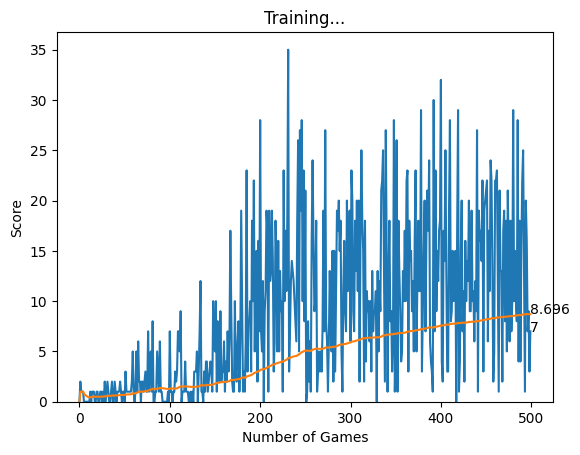

In [ ]:
trainDQN()

#SARSA Agent

Game 1 Score 0 Record: 0
Game 2 Score 0 Record: 0
Game 3 Score 1 Record: 1
Game 4 Score 0 Record: 1
Game 5 Score 1 Record: 1
Game 6 Score 0 Record: 1
Game 7 Score 0 Record: 1
Game 8 Score 0 Record: 1
Game 9 Score 0 Record: 1
Game 10 Score 0 Record: 1
Game 11 Score 1 Record: 1
Game 12 Score 0 Record: 1
Game 13 Score 1 Record: 1
Game 14 Score 0 Record: 1
Game 15 Score 0 Record: 1
Game 16 Score 1 Record: 1
Game 17 Score 1 Record: 1
Game 18 Score 1 Record: 1
Game 19 Score 0 Record: 1
Game 20 Score 0 Record: 1
Game 21 Score 1 Record: 1
Game 22 Score 1 Record: 1
Game 23 Score 0 Record: 1
Game 24 Score 0 Record: 1
Game 25 Score 2 Record: 2
Game 26 Score 1 Record: 2
Game 27 Score 1 Record: 2
Game 28 Score 0 Record: 2
Game 29 Score 1 Record: 2
Game 30 Score 0 Record: 2
Game 31 Score 0 Record: 2
Game 32 Score 1 Record: 2
Game 33 Score 0 Record: 2
Game 34 Score 1 Record: 2
Game 35 Score 0 Record: 2
Game 36 Score 0 Record: 2
Game 37 Score 1 Record: 2
Game 38 Score 1 Record: 2
Game 39 Score 2 Recor

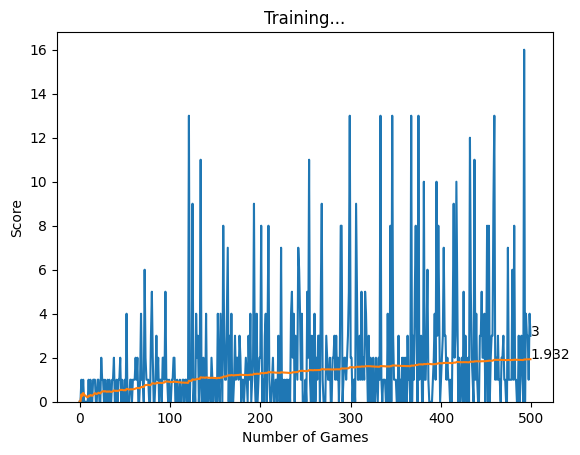

In [ ]:
trainSARSA()